In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

pd.set_option ("display.max_rows", None)
pd.set_option ("display.max_columns", None)
pd.set_option ("display.max_colwidth",200)

In [2]:
#https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

In [3]:
df=pd.read_csv("./Data/paso_2_agrupaciones_con_building_id.csv", sep=',')

In [4]:
df.shape

(818700, 36)

In [5]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [6]:
class_column = 'damage_grade'
classes_names = df['damage_grade'].unique()
print(class_column)
print(classes_names)

damage_grade
['Low-Medium' 'High-Severe']


In [7]:
# df[df['damage_grade']=="High-Severe"].count()/df.shape[0]

In [8]:
# df[df['damage_grade']=="Low-Medium"].count()/df.shape[0]

In [9]:
def curva_precision_recall(clf, X, y):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    from inspect import signature

    y_scores = clf.predict_proba(X)[:,1]
    precision, recall, ths = precision_recall_curve(y, y_scores)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.plot(recall[1:], ths,'r--')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    average_precision = average_precision_score(y, y_scores)

    plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(average_precision));

In [10]:
def curva_precision(clf, X, y):
    y_scores = clf.predict_proba(X)[:,1]
    unicos = np.unique(y_scores)
    tam = []
    precision = []
    for th in unicos:
        inds = np.where(y_scores>=th)[0]
        tam.append(len(inds)/len(y))
        precision.append((y[inds]==1).mean())

    plt.plot(tam, precision)
    plt.fill_between(tam, precision, alpha=0.2, color='b')

    plt.xlabel('volumen alarmas')
    plt.ylabel('Precisión')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

In [11]:
df=df.replace(['Low-Medium', 'High-Severe'], [0, 1])

In [12]:
X= df.drop(["damage_grade"], axis=1)
y= df['damage_grade']

In [13]:
from sklearn.model_selection import train_test_split
X_cons, X_explo, y_cons, y_explo = train_test_split (X, y, test_size=0.2, random_state=0)

In [14]:
X_cons.shape,y_cons.shape,X_explo.shape,y_explo.shape

((654960, 34), (654960,), (163740, 34), (163740,))

In [15]:
# X_explo.groupby('ward_id').count()

In [16]:
IDs_cons = X_cons[["ward_id",'building_id']].copy()
IDs_explo=X_explo[["ward_id",'building_id']].copy()

In [17]:
X_cons=X_cons.drop(["building_id"],axis=1)
X_explo=X_explo.drop(["building_id"],axis=1)

In [18]:
X_cons.head()

,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
186608,220207,3,3.555348,6.447306,2.944439,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Private,3,0,Male,59,Other,Low,Low,1.098612,0
365751,240604,1,1.791759,5.525453,2.079442,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1,0,0,0,0,0,1,0,0,0,0,Private,1,0,Male,26,Tamang,Low,Low,1.945910,0
162357,210608,3,3.761200,5.645447,2.944439,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Private,2,0,Female,78,Sarki,Illiterate,Low,0.693147,0
573264,300204,2,3.496508,5.755742,2.639057,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber,Not attached,Rectangular,0,1,0,0,0,0,1,1,0,0,0,Private,1,1,Male,58,Brahman-Hill,Illiterate,Medium,2.197225,0
692933,310410,3,3.931826,7.188413,3.433987,Flat,Mud mortar-Stone/Brick,RCC/RB/RBC,RC,RCC/RB/RBC,Attached-1 side,Rectangular,0,0,0,0,0,1,0,0,0,0,0,Private,2,0,Female,23,Other,Medium,Low,1.791759,1


In [19]:
# X_cons = df.drop(["damage_grade"], axis=1)
X_cons =  pd.get_dummies(X_cons, drop_first= False) 

In [20]:
# X_explo = df.drop(["damage_grade"], axis=1)
X_explo =  pd.get_dummies(X_explo, drop_first= False) 

### COLINEADAS

In [21]:
X_cons=X_cons.drop(['caste_household_no_familias',  
'education_level_household_head_no_familias',  
'foundation_type_others',  'gender_household_head_Male',  
'gender_household_head_no_familias',  
'height_ft_pre_eq',  
'income_level_household_no_familias',
'land_surface_condition_No Flat',
'legal_ownership_status_Private',
'other_floor_type_Timber',
'plan_configuration_other',
'position_Not attached',
'roof_type_Bamboo/Timber-Light roof'
], axis=1)

X_explo=X_explo.drop(['caste_household_no_familias',  
'education_level_household_head_no_familias',  
'foundation_type_others',  'gender_household_head_Male',  
'gender_household_head_no_familias',  
'height_ft_pre_eq',  
'income_level_household_no_familias',
'land_surface_condition_No Flat',
'legal_ownership_status_Private',
'other_floor_type_Timber',
'plan_configuration_other',
'position_Not attached',
'roof_type_Bamboo/Timber-Light roof'
], axis=1)


### RFECV

In [22]:
# X_cons=X_cons.drop(["caste_household_Magar",
# "plan_configuration_Rectangular",
# "age_household_head",
# "roof_type_RCC/RB/RBC",
# "caste_household_Tamang",
# "has_superstructure_stone_flag",
# "education_level_household_head_Low",
# "other_floor_type_RCC/RB/RBC",
# "ground_floor_type_others",
# "legal_ownership_status_No Private",
# "has_superstructure_cement_mortar_stone",
# "position_Attached >1 side",
# "income_level_household_Low",
# "caste_household_Kami",
# "gender_household_head_Female",
# "ground_floor_type_RC",
# "land_surface_condition_Flat",
# "has_superstructure_cement_mortar_brick",
# "plan_configuration_L-shape",
# "caste_household_Rai",
# "caste_household_Damai/Dholi",
# "caste_household_Gurung",
# "caste_household_Sherpa",
# "count_families",
# "has_superstructure_rc_non_engineered",
# "has_superstructure_rc_engineered",
# "education_level_household_head_Illiterate",
# "has_superstructure_adobe_mud",
# "foundation_type_Mud mortar-Stone/Brick",
# "has_superstructure_mud_mortar_brick",
# "has_superstructure_other",
# "education_level_household_head_Medium",
# "caste_household_Other",
# "income_level_household_High",
# "roof_type_Bamboo/Timber-Heavy roof"], axis=1)

# X_explo=X_explo.drop(["caste_household_Magar",
# "plan_configuration_Rectangular",
# "age_household_head",
# "roof_type_RCC/RB/RBC",
# "caste_household_Tamang",
# "has_superstructure_stone_flag",
# "education_level_household_head_Low",
# "other_floor_type_RCC/RB/RBC",
# "ground_floor_type_others",
# "legal_ownership_status_No Private",
# "has_superstructure_cement_mortar_stone",
# "position_Attached >1 side",
# "income_level_household_Low",
# "caste_household_Kami",
# "gender_household_head_Female",
# "ground_floor_type_RC",
# "land_surface_condition_Flat",
# "has_superstructure_cement_mortar_brick",
# "plan_configuration_L-shape",
# "caste_household_Rai",
# "caste_household_Damai/Dholi",
# "caste_household_Gurung",
# "caste_household_Sherpa",
# "count_families",
# "has_superstructure_rc_non_engineered",
# "has_superstructure_rc_engineered",
# "education_level_household_head_Illiterate",
# "has_superstructure_adobe_mud",
# "foundation_type_Mud mortar-Stone/Brick",
# "has_superstructure_mud_mortar_brick",
# "has_superstructure_other",
# "education_level_household_head_Medium",
# "caste_household_Other",
# "income_level_household_High",
# "roof_type_Bamboo/Timber-Heavy roof"], axis=1)

In [23]:
X_cons.shape,y_cons.shape,X_explo.shape,y_explo.shape

((654960, 54), (654960,), (163740, 54), (163740,))

Hacemos el train y el test para el dataset de construcción

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X_cons, y_cons, test_size=0.3, random_state=0)

### Modelo RF

In [25]:
# Instaniate the classification model and visualizer
modelRF = RandomForestClassifier(n_estimators=100, random_state=0, max_features=None, n_jobs=-1,
                             max_depth=15)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=None, n_jobs=-1,
                       random_state=0)

In [26]:
print("Scoring training:", modelRF.score(X_train, y_train))
print("Scoring test    :", modelRF.score(X_test, y_test))

Scoring training: 0.8617734561761677
Scoring test    : 0.8208185741622898


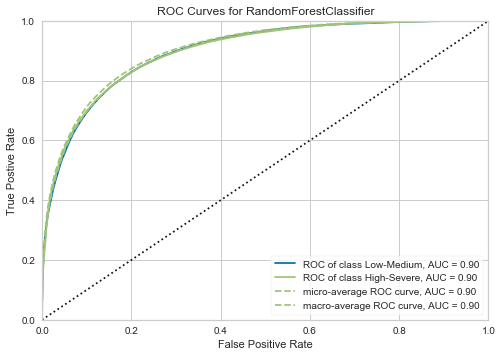

In [27]:
#RFClassifier()
visualizer = ROCAUC(modelRF, classes=classes_names)
                                    
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure   

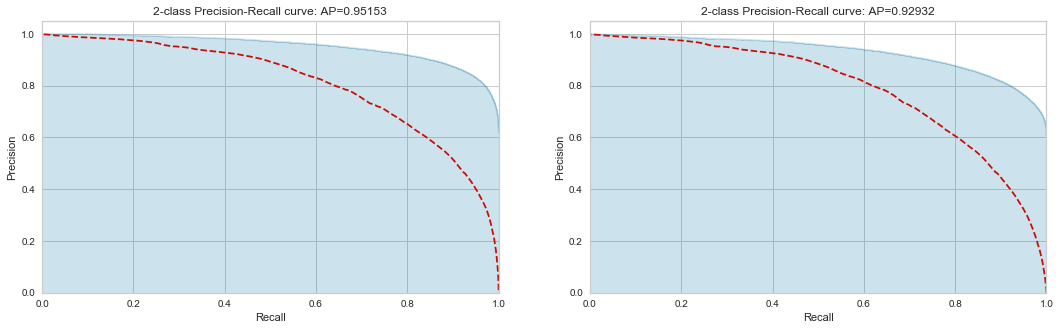

In [28]:
model = modelRF
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
curva_precision_recall(model, X_train, y_train)
plt.subplot(1,2,2)
curva_precision_recall(model, X_test, y_test)

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from inspect import signature
y_scores = modelRF.predict_proba(X_train)[:,1]
precision, recall, ths = precision_recall_curve(y_train, y_scores)

In [30]:
pr=pd.DataFrame({"precision":precision[1:],'recall':recall[1:], "ths":ths})

In [31]:
pr[(pr['ths']>0.7) & (pr['ths']<0.70111)].head(20)

,precision,recall,ths
209767,0.929359,0.757415,0.700006
209768,0.929359,0.757411,0.700006
209769,0.929359,0.757408,0.700009
209770,0.929358,0.757404,0.700010
209771,0.929358,0.757401,0.700017
209772,0.929358,0.757397,0.700022
209773,0.929357,0.757393,0.700022
209774,0.929362,0.757393,0.700029
209775,0.929361,0.757390,0.700033
209776,0.929361,0.757386,0.700034


In [32]:
pr[(pr['ths']>0.2) & (pr['ths']<0.70111)].head()

,precision,recall,ths
72828,0.735256,0.990920,0.200002
72829,0.735258,0.990920,0.200003
72830,0.735260,0.990920,0.200006
72831,0.735259,0.990916,0.200006
72832,0.735261,0.990916,0.200008


In [33]:
y_score = modelRF.predict_proba(X_test)[:,1]

In [34]:
modelRF.score(X_train, y_train)

0.8617734561761677

In [35]:
modelRF.score(X_test, y_test)

0.8208185741622898

In [36]:
modelRF.predict(X_test)[:15]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int64)

In [37]:
predic_explo=pd.DataFrame(modelRF.predict(X_explo))

In [38]:
y_explo.head(20)

570202    1
568617    0
701889    1
757354    0
740032    1
88480     0
190536    1
310057    1
333482    1
169424    1
598487    1
670426    1
769219    1
312101    1
733825    0
120467    1
446334    0
735782    0
439757    0
366573    1
Name: damage_grade, dtype: int64

In [39]:
prob_explo_RF =modelRF.predict_proba(X_explo)[:,1]

In [40]:
prob_explo_RF = pd.DataFrame({"ward_id":IDs_explo['ward_id'],'building_id':IDs_explo['building_id'], "damage_grade_prob":prob_explo_RF})

In [41]:
prob_explo_RF.head()

,ward_id,building_id,damage_grade_prob
570202,300408,301403000471,0.702170
568617,300302,301302010401,0.047216
701889,310502,312705001011,0.390709
757354,360814,361809000811,0.306060
740032,360108,360403000451,0.888182


In [42]:
prob_explo_RF["vdcmun_id"] = prob_explo_RF["ward_id"].astype(str).str[:-2].astype(np.int64)
prob_explo_RF["district_id"] = prob_explo_RF["vdcmun_id"].astype(str).str[:-2].astype(np.int64)

In [43]:
prob_explo_RF["real_class"] = y_explo.values

In [44]:
prob_explo_RF.sort_values(by = 'damage_grade_prob', ascending=False).head(500)

,ward_id,building_id,damage_grade_prob,vdcmun_id,district_id,real_class
773652,360602,363401000631,1.000000,3606,36,1
773814,360602,363402001011,1.000000,3606,36,1
773714,360602,363402000221,0.999797,3606,36,1
773743,360602,363402000461,0.999797,3606,36,1
242671,220607,224709001451,0.999794,2206,22,1
223549,220604,223405001851,0.999781,2206,22,1
225720,220606,223506001051,0.999707,2206,22,1
773808,360602,363402000961,0.999672,3606,36,1
773984,360602,363404000621,0.999672,3606,36,1
773995,360602,363404000721,0.999672,3606,36,1


In [45]:
prob_explo_RF.to_csv("./Data/prob_explo_con2clases_building_id_RF_COLINEADAS.csv")